# Project Overview
This project implements a deep learning model to classify chest X-ray images into "Normal" and "Pneumonia".

## Key Objectives:
1. **Automate the diagnosis** of pneumonia from X-ray images.
2. **Use transfer learning** with a pre-trained ResNet-50 model.e.


### Importing Required Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

### Dataset Directory Paths

- **Training Directory (`train_dir`)**: 
  - This directory contains the training images used to train the model. These images are loaded into the model to learn from and update its weights.
  
- **Validation Directory (`val_dir`)**: 
  - The validation set is used during the training process to tune the model's hyperparameters and monitor its performance. The model is evaluated on the validation set at regular intervals during training to detect overfitting.
  
- **Test Directory (`test_dir`)**: 
  - After the model is trained and tuned, it is evaluated on the test set. This provides an unbiased evaluation of the model’s performance on data it has never seen before.


In [8]:
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

### Image Size and Batch Size

- **Image Size (`IMG_SIZE`)**:
  - The input size for the images is set to **224x224** pixels. This is a common input size for models like **ResNet-50**, as it balances model accuracy and computation efficiency.
  - All input images will be resized to this resolution before being fed into the model.

- **Batch Size (`BATCH_SIZE`)**:
  - The **batch size** is set to **32**, meaning the model will process **32 images** in each training step before updating the model's weights.
  - A batch size of 32 is a typical choice, balancing memory consumption and computation time. Larger batch sizes may speed up training, but they require more memory.


In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

### Data Augmentation with `ImageDataGenerator`

- **Rescaling (`rescale`)**: 
  - The pixel values of images are rescaled to the range [0, 1] by dividing each pixel value by **255**. This ensures the model works with normalized values, which typically helps with training stability.

- **Rotation (`rotation_range`)**: 
  - The images are randomly rotated within a range of **20 degrees**. This helps the model generalize better by simulating various orientations of the images.

- **Width Shift (`width_shift_range`)**: 
  - Images can be randomly shifted horizontally by up to **20%** of the image's width. This simulates slight variations in object positioning within the image.

- **Height Shift (`height_shift_range`)**: 
  - Images can be randomly shifted vertically by up to **20%** of the image's height, providing more variations in image positioning.

- **Shear (`shear_range`)**: 
  - Random **shear transformations** (affine transformation that distorts the image along one axis) are applied within a range of **20%**, helping the model become more robust to distorted images.

- **Zoom (`zoom_range`)**: 
  - Random **zoom** is applied to the images, varying by up to **20%**, which simulates different object distances and improves the model's generalization.

- **Horizontal Flip (`horizontal_flip`)**: 
  - The images are randomly flipped **horizontally**. This adds further variety to the dataset and helps the model learn to detect objects irrespective of orientation.


In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

### Data Preprocessing for Validation and Test Datasets

- **Validation Data Generator (`val_datagen`)**:
  - The `ImageDataGenerator` for the **validation dataset** applies **rescaling** of pixel values by dividing by **255** to normalize the images into the range [0, 1].
  - The rescaling is the only transformation applied, as no augmentation is necessary for validation. The goal is to evaluate the model on data that closely resembles the real-world test data.

- **Test Data Generator (`test_datagen`)**:
  - Similarly, the `ImageDataGenerator` for the **test dataset** only applies **rescaling** of pixel values to [0, 1] by dividing by 255.
  - No augmentation is applied to the test set, as we want to assess the model's performance on the original data it was trained on.


In [11]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

### Training Data Generator (`train_generator`)

- **`flow_from_directory()`**:
  - This method generates batches of image data directly from the **`train_dir`** directory. It automatically labels the images based on the folder names (in this case, "Normal" and "Pneumonia").
  
- **Target Size (`target_size`)**:
  - The images are resized to the target size of **224x224** pixels as defined in the **`IMG_SIZE`** variable. This ensures all images are of the correct size for the ResNet-50 model.

- **Batch Size (`batch_size`)**:
  - The batch size is set to **32**, meaning that **32 images** are processed in each training step before the model updates its weights.

- **Class Mode (`class_mode`)**:
  - The **`class_mode`** is set to **'binary'**, indicating this is a binary classification task where the model will predict one of two possible classes: "Normal" or "Pneumonia".

- **Data Augmentation**:
  - The **`train_datagen`** object is used to apply data augmentation (such as rotation, flipping, and shifting) to the images during training. This helps to generate a diverse dataset and prevents overfitting.


In [12]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.


### Validation Data Generator (`val_generator`)

- **`flow_from_directory()`**:
  - This method generates batches of image data directly from the **`val_dir`** directory. It automatically assigns labels based on the subdirectory names (e.g., "Normal" and "Pneumonia").

- **Target Size (`target_size`)**:
  - All images in the validation dataset are resized to **224x224** pixels as specified in the **`IMG_SIZE`** variable. This ensures that the images are of the correct size for the ResNet-50 model.

- **Batch Size (`batch_size`)**:
  - The batch size is set to **32**, meaning that the generator will load **32 images** at a time during validation.

- **Class Mode (`class_mode`)**:
  - The **`class_mode`** is set to **'binary'**, indicating that this is a binary classification task. The generator will label images as either "Normal" or "Pneumonia" based on their folder structure.

- **No Data Augmentation**:
  - Unlike the training set, the **`val_datagen`** object does not apply any data augmentation. The validation data is simply rescaled to [0, 1], ensuring that it remains consistent with the model's evaluation criteria.


In [13]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 16 images belonging to 2 classes.


### Test Data Generator (`test_generator`)

- **`flow_from_directory()`**:
  - This method generates batches of image data directly from the **`test_dir`** directory. It automatically assigns labels based on the subdirectory names (e.g., "Normal" and "Pneumonia").

- **Target Size (`target_size`)**:
  - All images in the test dataset are resized to **224x224** pixels, as specified in the **`IMG_SIZE`** variable. This ensures compatibility with the ResNet-50 model input requirements.

- **Batch Size (`batch_size`)**:
  - The batch size is set to **32**, meaning that the generator will load **32 images** at a time during testing.

- **Class Mode (`class_mode`)**:
  - The **`class_mode`** is set to **'binary'**, indicating that this is a binary classification task. The test data will be labeled as either "Normal" or "Pneumonia" based on their folder structure.

- **No Data Augmentation**:
  - The **`test_datagen`** object applies only **rescaling** to the test images, ensuring the pixel values are scaled between [0, 1]. No augmentation is performed on the test data, as it is used to evaluate the final model performance on unseen data.


In [14]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 624 images belonging to 2 classes.


### Base Model: ResNet50

- **`ResNet50`**:
  - This line loads the **ResNet50** model, a deep residual network with **50 layers**. The model is pre-trained on the **ImageNet** dataset, which contains millions of labeled images across 1,000 categories.
  
- **`weights='imagenet'`**:
  - The **`weights='imagenet'`** argument loads the **pre-trained weights** from ImageNet. This allows the model to benefit from the knowledge gained by training on a large dataset, making it more effective for transfer learning.

- **`include_top=False`**:
  - By setting **`include_top=False`**, the fully connected layers (the top classification layers) of the original ResNet50 model are excluded. This is because we intend to use the pre-trained feature extraction layers and add custom classification layers on top of them, specific to the pneumonia classification task.

- **`input_shape=(224, 224, 3)`**:
  - The **`input_shape`** is set to **(224, 224, 3)**, specifying the input size for the model. The images are resized to **224x224 pixels** with **3 color channels (RGB)** to match the input requirements of ResNet50.


In [15]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

### Model Architecture

The model is built using the **Sequential API** and consists of several layers stacked on top of the pre-trained **ResNet50** base model.

- **Base Model (`base_model`)**:
  - The pre-trained **ResNet50** model is used as the feature extractor. It extracts relevant features from the input images, which are then passed to the following layers.

- **Global Average Pooling (`GlobalAveragePooling2D`)**:
  - This layer is used to reduce the spatial dimensions (height and width) of the feature maps output by the ResNet50 model.
  - It computes the average of each feature map, resulting in a 1D vector that can be passed to the fully connected layers.

- **Dense Layer (`Dense(128, activation='relu')`)**:
  - This is a fully connected layer with **128 units** and **ReLU** activation. The ReLU activation function introduces non-linearity to the model, allowing it to learn complex patterns.

- **Dropout Layer (`Dropout(0.5)`)**:
  - This layer applies **dropout** with a rate of **50%** to randomly set half of the neurons to zero during training. This helps prevent overfitting by forcing the model to rely on a more diverse set of features.

- **Output Layer (`Dense(1, activation='sigmoid')`)**:
  - The final layer is a fully connected layer with **1 unit** and **sigmoid** activation. The sigmoid activation function outputs a value between 0 and 1, representing the probability of the input image being classified as **Pneumonia** (1) or **Normal** (0).


In [16]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') 
])

### Freezing the Base Model and Compiling the Model

- **Freezing the Base Model (`base_model.trainable = False`)**:
  - The **ResNet50** model is pre-trained on ImageNet. To retain the learned features from ImageNet, we freeze the layers of the base model by setting **`trainable = False`**.
  - This ensures that the weights of the ResNet50 layers will not be updated during training, allowing the custom layers (added on top) to learn the specific features for the pneumonia classification task.

- **Compiling the Model (`model.compile()`)**:
  - **Optimizer**: The model is compiled with the **Adam optimizer**, which is popular for training deep learning models. The learning rate is set to **0.001**, balancing the speed of training and stability.
  
  - **Loss Function**: The **binary cross-entropy loss** function is used because the task is a binary classification (Normal vs. Pneumonia). This loss function is appropriate for models that output a probability (in this case, using the **sigmoid activation**).
  
  - **Metrics**: The **accuracy** metric is used to evaluate the model’s performance during training and testing. It computes the proportion of correct predictions made by the model.


In [17]:
base_model.trainable = False

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


### Model Training

- **`model.fit()`**:
  - The **`fit()`** function is used to train the model. It requires the training and validation data generators, along with several other hyperparameters such as the number of epochs and steps per epoch.

- **Training Data (`train_generator`)**:
  - The **`train_generator`** provides the data for training the model. It uses real-time data augmentation to feed batches of training images to the model.

- **Validation Data (`val_generator`)**:
  - The **`val_generator`** provides the validation data used to evaluate the model’s performance after each epoch. This helps monitor if the model is overfitting.

- **Epochs (`epochs`)**:
  - The model is trained for **10 epochs**, meaning the entire training dataset will be processed 10 times. You can adjust this value based on the complexity of the dataset and the model.

- **Steps per Epoch (`steps_per_epoch`)**:
  - The **`steps_per_epoch`** is the number of batches to be processed in each epoch. It is calculated by dividing the total number of training samples (`train_generator.samples`) by the batch size (`BATCH_SIZE`).
  
- **Validation Steps (`validation_steps`)**:
  - Similar to **`steps_per_epoch`**, **`validation_steps`** is the number of validation batches to process at the end of each epoch, determined by the validation dataset size divided by the batch size.


In [19]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE
)

Epoch 1/10
163/163 [==============================] - 345s 2s/step - loss: 0.5837 - accuracy: 0.7343
Epoch 2/10
163/163 [==============================] - 348s 2s/step - loss: 0.5435 - accuracy: 0.7450
Epoch 3/10
163/163 [==============================] - 346s 2s/step - loss: 0.5129 - accuracy: 0.7469
Epoch 4/10
163/163 [==============================] - 347s 2s/step - loss: 0.4751 - accuracy: 0.7586
Epoch 5/10
163/163 [==============================] - 344s 2s/step - loss: 0.4480 - accuracy: 0.7697
Epoch 6/10
163/163 [==============================] - 344s 2s/step - loss: 0.4360 - accuracy: 0.7759
Epoch 7/10
163/163 [==============================] - 344s 2s/step - loss: 0.4329 - accuracy: 0.7730
Epoch 8/10
163/163 [==============================] - 345s 2s/step - loss: 0.4257 - accuracy: 0.7492
Epoch 9/10
163/163 [==============================] - 349s 2s/step - loss: 0.4174 - accuracy: 0.7876
Epoch 10/10
163/163 [==============================] - 345s 2s/step - loss: 0.4126 - accura

### Fine-Tuning the Model

- **Unfreezing the Base Model (`base_model.trainable = True`)**:
  - Initially, the layers of the **ResNet50** model were frozen to retain the pre-trained features. Now, by setting **`trainable = True`**, we unfreeze the layers, allowing them to be fine-tuned during training.
  - Fine-tuning the base model helps the network learn more specific features related to pneumonia classification, improving model performance.

- **Re-compiling the Model (`model.compile()`)**:
  - After unfreezing the base model, we **recompile** the model to update the optimizer settings.
  
  - **Optimizer**: The model is compiled with the **Adam optimizer**, which is widely used due to its adaptive learning rate capabilities. The learning rate is set to **0.0001**, which is smaller than the initial learning rate to allow gradual and fine-tuned updates to the model’s weights.

  - **Loss Function**: The **binary cross-entropy loss** function is used, as we are working on a binary classification task (Normal vs. Pneumonia).
  
  - **Metrics**: The **accuracy** metric is chosen to track the proportion of correct predictions made by the model during training and evaluation.


In [20]:
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Fine-Tuning the Model

- **`model.fit()`**:
  - The **`fit()`** function is used to train the model after unfreezing the layers of the base model (ResNet50). This fine-tunes the model to the pneumonia detection task by updating the weights of both the custom layers and the pre-trained ResNet50 layers.

- **Training Data (`train_generator`)**:
  - The **`train_generator`** provides the training data with augmentation, allowing the model to learn from a diverse set of images.

- **Validation Data (`val_generator`)**:
  - The **`val_generator`** provides the validation data for monitoring model performance during training. This helps assess whether the model is overfitting to the training data.

- **Epochs (`epochs`)**:
  - The model is trained for **10 epochs**. During each epoch, the model processes all the training data, and its performance is evaluated on the validation data.

- **Steps per Epoch (`steps_per_epoch`)**:
  - The **`steps_per_epoch`** is calculated by dividing the total number of samples in the training dataset (**`train_generator.samples`**) by the batch size (**`BATCH_SIZE`**). This ensures the model processes all the training data in each epoch.

- **Validation Steps (`validation_steps`)**:
  - Similarly, **`validation_steps`** is calculated by dividing the total number of validation samples (**`val_generator.samples`**) by the batch size. This defines how many batches of validation data will be processed after each epoch.


In [21]:
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE
)

Epoch 1/10
163/163 [==============================] - 1536s 9s/step - loss: 0.2038 - accuracy: 0.9325
Epoch 2/10
163/163 [==============================] - 1534s 9s/step - loss: 0.1068 - accuracy: 0.9618
Epoch 3/10
163/163 [==============================] - 1528s 9s/step - loss: 0.0761 - accuracy: 0.9745
Epoch 4/10
163/163 [==============================] - 1526s 9s/step - loss: 0.0653 - accuracy: 0.9770
Epoch 5/10
163/163 [==============================] - 1615s 10s/step - loss: 0.0555 - accuracy: 0.9816
Epoch 6/10
163/163 [==============================] - 1542s 9s/step - loss: 0.0522 - accuracy: 0.9797
Epoch 7/10
163/163 [==============================] - 1620s 10s/step - loss: 0.0438 - accuracy: 0.9854
Epoch 8/10
163/163 [==============================] - 1538s 9s/step - loss: 0.0385 - accuracy: 0.9858
Epoch 9/10
163/163 [==============================] - 1496s 9s/step - loss: 0.0501 - accuracy: 0.9826
Epoch 10/10
163/163 [==============================] - 1476s 9s/step - loss: 0.0

### Model Evaluation on the Test Set

- **`model.evaluate()`**:
  - The **`evaluate()`** function is used to assess the performance of the trained model on the **test dataset**. This function returns the **loss** and **accuracy** metrics for the model on the unseen test data.

- **Test Data (`test_generator`)**:
  - The **`test_generator`** provides the test dataset, which is used to evaluate the final model's performance after training. No data augmentation is applied to the test set to ensure an unbiased evaluation of the model's generalization ability.

- **Test Loss and Accuracy**:
  - **Test Loss**: The loss value represents how well the model’s predictions match the actual labels on the test data. A lower loss indicates better performance.
  - **Test Accuracy**: The accuracy represents the proportion of correct predictions made by the model on the test set. This metric helps measure the overall classification performance.

- **Printing Test Accuracy**:
  - The test accuracy is printed as a percentage to show how well the model performed on the test set. The result is multiplied by 100 to convert it into a percentage format.


In [27]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

20/20 [==============================] - 38s 2s/step - loss: 0.6414 - accuracy: 0.8702
Test Accuracy: 87.02%


### Model Prediction and Evaluation Metrics

- **Importing Evaluation Metrics**:
  - Several evaluation metrics are imported from **`sklearn.metrics`** to assess the model’s performance:
    - **`accuracy_score`**: Measures the overall accuracy of the model.
    - **`precision_score`**: Calculates the precision, or the proportion of true positives among all predicted positives.
    - **`recall_score`**: Measures the recall, or the proportion of true positives among all actual positives.
    - **`f1_score`**: The harmonic mean of precision and recall, providing a balanced measure of the model's performance.
    - **`confusion_matrix`**: Displays the number of true positives, false positives, true negatives, and false negatives.
    - **`classification_report`**: Provides a detailed report containing precision, recall, F1-score, and support for each class.

- **Model Predictions (`model.predict()`)**:
  - The **`model.predict()`** function generates **predictions** for the test dataset. Since the output layer uses **sigmoid activation**, the predictions are probabilities between 0 and 1.

- **Converting Probabilities to Classes**:
  - The **predictions** are thresholded at **0.5**. If the predicted probability is greater than 0.5, the class label is considered **1** (Pneumonia), and if it’s less than or equal to 0.5, it’s considered **0** (Normal).
  - The **`astype("int32")`** converts the binary class labels to integers (0 or 1).


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np


predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32") 

### Model Evaluation and Metrics Calculation

- **True Classes (`true_classes`)**:
  - **`test_generator.classes`** contains the true class labels for each sample in the test dataset. These values are used as the ground truth for comparison with the predicted classes.

- **Class Labels (`class_labels`)**:
  - **`test_generator.class_indices.keys()`** provides the class labels (e.g., "Normal", "Pneumonia"). These labels correspond to the numeric class values used for classification in the dataset.

- **Performance Metrics**:
  - **Accuracy (`accuracy_score`)**: This metric calculates the proportion of correct predictions (both true positives and true negatives) out of the total number of samples.
  
  - **Precision (`precision_score`)**: Precision is the ratio of true positives to the total predicted positives. It answers the question: "Of all the cases predicted as pneumonia, how many were actually pneumonia?"
  
  - **Recall (`recall_score`)**: Recall is the ratio of true positives to the total actual positives. It answers the question: "Of all the actual pneumonia cases, how many were correctly identified?"
  
  - **F1 Score (`f1_score`)**: The F1 score is the harmonic mean of precision and recall, providing a balance between the two metrics. It is particularly useful when dealing with imbalanced datasets.

- **Confusion Matrix (`confusion_matrix`)**:
  - The **confusion matrix** is a table that describes the performance of a classification model. It shows the number of true positives, false positives, true negatives, and false negatives, allowing you to better understand the model's classification errors.


In [29]:
true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)
conf_matrix = confusion_matrix(true_classes, predicted_classes)

In [31]:
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Precision: 0.6402569593147751
Recall: 0.7666666666666667
F1 Score: 0.6977829638273045

Confusion Matrix:
[[ 66 168]
 [ 91 299]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.42      0.28      0.34       234
   PNEUMONIA       0.64      0.77      0.70       390

    accuracy                           0.58       624
   macro avg       0.53      0.52      0.52       624
weighted avg       0.56      0.58      0.56       624



### ROC Curve and AUC Evaluation

- **Importing Functions**:
  - **`roc_auc_score`**: This function calculates the **Area Under the Curve (AUC)** for the **Receiver Operating Characteristic (ROC)** curve. A higher AUC indicates better model performance.
  - **`roc_curve`**: This function computes the **False Positive Rate (FPR)** and **True Positive Rate (TPR)** at various classification thresholds.

- **Predicted Probabilities (`predicted_probs`)**:
  - The **`predictions.ravel()`** function flattens the predictions array into a one-dimensional array. This ensures the predictions are in the correct shape for evaluation and plotting.

- **AUC Score Calculation (`roc_auc_score`)**:
  - The **AUC** is computed by comparing the **true classes** with the **predicted probabilities**. The AUC score gives us a summary of the model's ability to discriminate between positive and negative classes.
  - A value closer to 1.0 indicates excellent performance, while a value around 0.5 indicates random guessing.

- **ROC Curve (`roc_curve`)**:
  - The **`roc_curve`** function calculates the **False Positive Rate (FPR)** and **True Positive Rate (TPR)** for various thresholds. These values are used to plot the ROC curve.
  - **FPR**: The proportion of negative samples incorrectly classified as positive (false positives).
  - **TPR**: The proportion of actual positive samples correctly classified as positive (true positives).

- **Plotting the ROC Curve**:
  - The **`plt.plot()`** function is used to plot the ROC curve. The curve plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)**.
  - A diagonal line (`'k--'`) representing **random guessing** is also plotted for reference. If the model performs well, the ROC curve should be above this diagonal line.

- **Graph Details**:
  - The **x-axis** represents the **False Positive Rate (FPR)**, and the **y-axis** represents the **True Positive Rate (TPR)**.
  - The **legend** displays the AUC score, and the **grid** is added for better visualization.


AUC Score: 0.5130780188472497


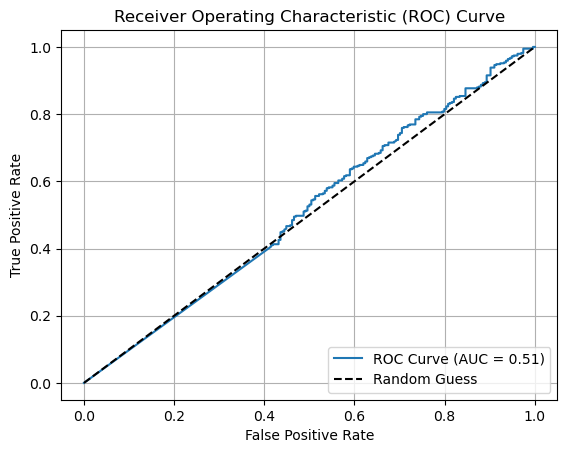

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

predicted_probs = predictions.ravel()  

auc = roc_auc_score(true_classes, predicted_probs)
print("AUC Score:", auc)

fpr, tpr, thresholds = roc_curve(true_classes, predicted_probs)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


### Plotting Training Accuracy and Loss

- **Training Accuracy Plot**:
  - **`train_acc`**: This variable contains the training accuracy for each epoch, as recorded during training. It is extracted from the **`history.history['accuracy']`** object.
  - The **training accuracy plot** shows how the model's accuracy evolves over the course of the training process, helping to visualize if the model is improving or overfitting.

- **Training Loss Plot**:
  - **`train_loss`**: This variable contains the training loss values for each epoch, recorded during training. It is extracted from **`history.history['loss']`**.
  - The **training loss plot** helps track how the model's loss decreases with each epoch. A decreasing loss typically indicates that the model is learning and improving its predictions.

- **Epochs**:
  - **`epochs`**: This is a range object starting from 1, representing the number of epochs the model has been trained for. It is used as the x-axis in both plots.

- **Plot Details**:
  - **Accuracy Plot**: The x-axis shows the **epoch number**, and the y-axis shows the **accuracy**. The plot tracks the **training accuracy** for each epoch.
  - **Loss Plot**: The x-axis shows the **epoch number**, and the y-axis shows the **training loss**. The plot tracks the **training loss** for each epoch.
  
- **Graph Features**:
  - **`plt.legend()`**: Adds a legend to the plot to label the line.
  - **`plt.grid()`**: Adds gridlines to the plot for better readability and comparison.
  - **`plt.show()`**: Displays the plot for both accuracy and loss.

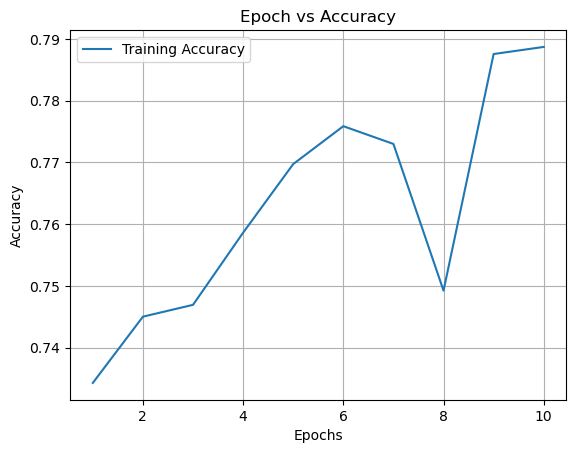

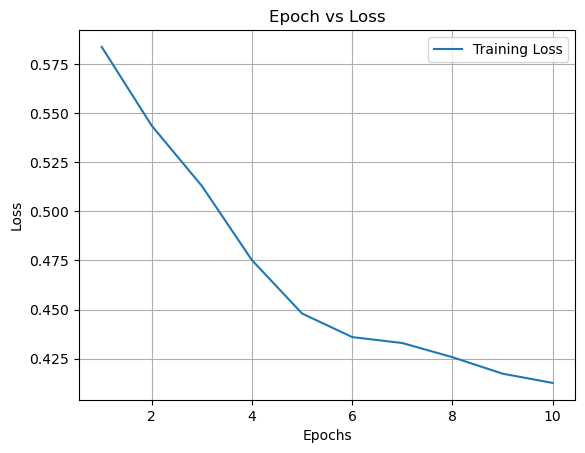

In [34]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
epochs = range(1, len(train_acc) + 1)

plt.figure()
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(epochs, train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid()
plt.show()
